# Predicting Customer Term Deposits

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandera as pa
from pandera import Column, Check

## Summary

For this analysis, we built a logistic regression classification model using data from a Portuguese banking institution to predict whether a bank client will agree to open a term deposit. A term deposits is a secure investment option where individuals deposit money for a fixed term at an agreed interest rate, with the principal amount and interest paid out at the end of the term.  The logistic regression model achieved a macro-average recall of 0.68 and an AUC score of 0.75, indicating moderate predictive power. While the model performs well at identifying non-subscribers, it struggles with precision (0.23) for subscribers. In the 13,564 test cases, the model correctly predicted 1,058 new subscribers, but incorrectly predicted 3525 false positives (clients predicted to subscribe when they would not). These false positives would result in additional phone calls being made, despite not leading to a successful subscription. However, by applying the model’s predictions, the number of phone calls would be significantly reduced, while the overall success rate for subscriber identification would increase to 23.09% (up from 11.78% if all 13,564 calls were made). Moving forward, improving precision should be a key focus for future modeling efforts to enhance both the accuracy and cost-effectiveness of the campaign.

## Introduction 

According to a poll from Investor's Edge, the direct investing division of CIBC, 79% of Canadians acknowledge that it is important to know how to invest their money (Gonzales 2024). However, only 48% of Canadians are investing their money annually (Gonzales 2024). A large proportion of those hesitant to invest (57%) stated a fear of losing money as the reason (Gonzales 2024). It’s important for banks to understand Canadians’ investment habits in order to better provide services to support Canadians investment decisions. Keeping this in mind, many banks offer a lower risk investment option called bank term deposits.

A bank term deposit is a type of secure investment that allows individuals to deposit a lump sum amount of money for a fixed period of time (term). The period of time can range from short-term to long-term. The money is “locked in” for the duration of the term at an agreed upon interest rate. At the end of the term, the customer will receive the initial deposit along with the additional accumulated interest. It’s important to note that term deposits are very low risk and the initial investment is protected (IslandSavings, n.d.)

In this analysis, we aim to determine whether a machine learning model can predict if a customer will agree to open a term deposit, using data from a Portuguese banking institution. Answering this question will be valuable for the banking institution, as it will allow them to focus their calling campaign on customers that are more likely to agree to a term deposit. This targeted approach will save valuable time and resources, as fewer customers will need to be contacted in future campaigns based on the models predictions. Additionally, this analysis will also help the bank understand their customers investment preferences, enabling them to build stronger relationship with their client-base and offer investment options that align with customer needs.

# Methods

## Data

The dataset used in this project is from a direct marketing campaign conducted via phone calls from a Portuguese banking institution. The dataset was created by S. Moro, P. Rita, and P. Cortez and collected between May 2008 and November 2010 (Moro, Rita, and Cortez, 2014). Our team sourced the data from the UCI Machine Learning Repository which can be accessed directly [here](https://archive.ics.uci.edu/dataset/222/bank+marketing) specifically [this file](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip). Each row in the dataset represents a bank client, with 17 features that capture aspects of the clients characteristics, as well as whether the client opened a term deposit or not. Some features are more specific to the individual (e.g. age, job, marital status and education level), while others pertain to their relationship with the bank, such as such as past interactions through previous campaigns, or the number of days since the last contact.

## Step 1: Data Loading

Objective: Provide context about the dataset and load it for analysis.

In [2]:
import requests
import zipfile
import os
import shutil

url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
download_path = "../data/raw/bank+marketing.zip"
extraction_path = "../data/raw/bank_marketing"  


response = requests.get(url)
os.makedirs(os.path.dirname(download_path), exist_ok=True)
with open(download_path, 'wb') as f:
    f.write(response.content)


with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


nested_zip_path = os.path.join(extraction_path, "bank.zip")
with zipfile.ZipFile(nested_zip_path, 'r') as nested_zip_ref:
    nested_zip_ref.extractall("../data/raw/")


shutil.rmtree(extraction_path) 
os.remove(download_path)  

In [3]:
# Path to the CSV file
file_path = "../data/raw/bank-full.csv"

# Load the data
data = pd.read_csv(file_path, sep=';')

# Preview the first few rows
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Step 2: Data Cleaning and Missing Value Handling

Objective: Standardize missing values, clean data, and remove irrelevant columns.

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64


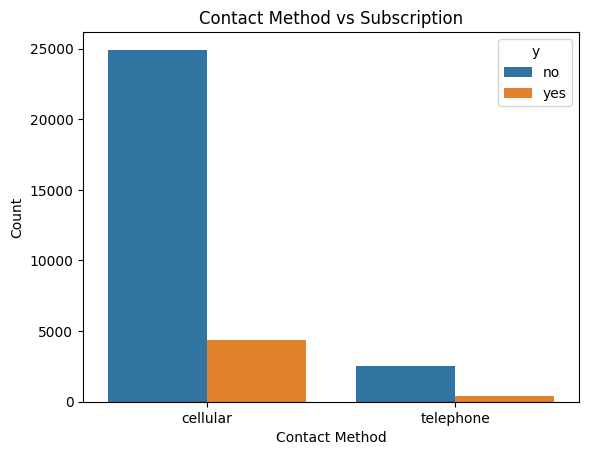

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
y            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  y          45211 non-nul

In [4]:
# Replace "unknown" with NaN
data.replace('unknown', np.nan, inplace=True)

# Check for missing values
print(data.isnull().sum())

# Visualize the relationship between 'contact' and 'y' to evaluate its importance
sns.countplot(x='contact', hue='y', data=data)
plt.title('Contact Method vs Subscription')
plt.xlabel('Contact Method')
plt.ylabel('Count')
plt.show()

# Impute missing values in 'job' and 'education' with mode
data['job'] = data['job'].fillna(data['job'].mode()[0])
data['education'] = data['education'].fillna(data['education'].mode()[0])

# Decision about 'contact':
# Based on the visualization, replace missing values in 'contact' with 'Unknown Contact'
data['contact'] = data['contact'].fillna('Unknown Contact')

# Drop the 'poutcome' column due to excessive missing values
data.drop(columns=['poutcome'], inplace=True)

# Drop the 'duration' column as it is deemed irrelevant
data.drop(columns=['duration'], inplace=True)

# Verify the cleaned dataset
print(data.isnull().sum())
print(data.info())


To prepare the dataset for analysis, we addressed missing values and removed irrelevant columns. Missing values in job and education were imputed with the mode, as their proportions were small, and mode imputation preserves their categorical nature. For contact, we visualized its relationship with the target variable (y) and found that contact method correlates with subscription rates. Based on this insight, missing values in contact were replaced with "Unknown Contact" to retain its predictive value. Columns like poutcome, which had excessive missing values (82%), were dropped to reduce noise, while duration was removed to prevent data leakage, as it directly correlates with the target variable. These cleaning decisions ensure a clean, consistent dataset, while preserving key patterns for predictive modeling.

## Step 3: Exploratory Data Analysis (EDA)

Objective: Gain insights into the dataset using summary statistics and visualizations.

### 3.1 Summary Statistics Code

In [5]:
# Generate summary statistics for numerical columns
print(data.describe())

                age        balance           day      campaign         pdays  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419      2.763841     40.197828   
std       10.618762    3044.765829      8.322476      3.098021    100.128746   
min       18.000000   -8019.000000      1.000000      1.000000     -1.000000   
25%       33.000000      72.000000      8.000000      1.000000     -1.000000   
50%       39.000000     448.000000     16.000000      2.000000     -1.000000   
75%       48.000000    1428.000000     21.000000      3.000000     -1.000000   
max       95.000000  102127.000000     31.000000     63.000000    871.000000   

           previous  
count  45211.000000  
mean       0.580323  
std        2.303441  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  


The summary statistics provide an overview of the central tendencies, variability, and range of the numerical columns in the dataset. The age column, with a mean of 41 years and a standard deviation of 10.6, indicates a diverse range from 18 to 95 years. The balance column shows significant variability, with a wide range from -8019 to 102127 and a standard deviation over 3000, suggesting the presence of outliers. The day column, representing the last contact day, is evenly distributed across the month, while campaign has a median of 2 and a maximum of 63, showing that most clients were contacted only a few times. The pdays column has many entries with -1, likely indicating no prior contact, while previous has a low mean (0.58) but a maximum of 275, highlighting infrequent yet extreme cases. These statistics offer critical insights into the dataset’s distribution and help identify features that may need further preprocessing.

### 3.2 Distribution of the Target Variable

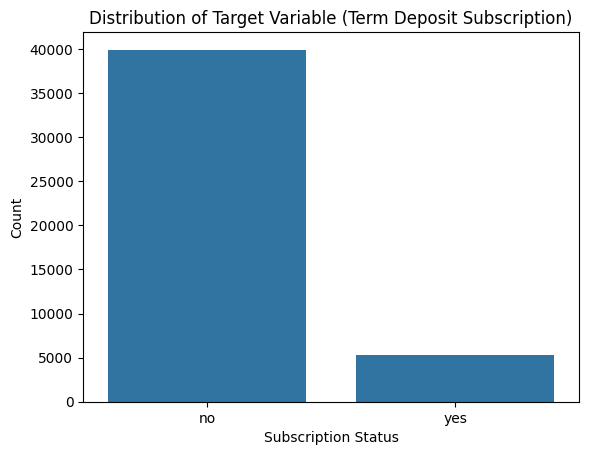

In [6]:
# Visualize the distribution of the target variable
sns.countplot(x='y', data=data)
plt.title('Distribution of Target Variable (Term Deposit Subscription)')
plt.xlabel('Subscription Status')
plt.ylabel('Count')
plt.show()


### 3.3 Relationships Between Features and Target Code:

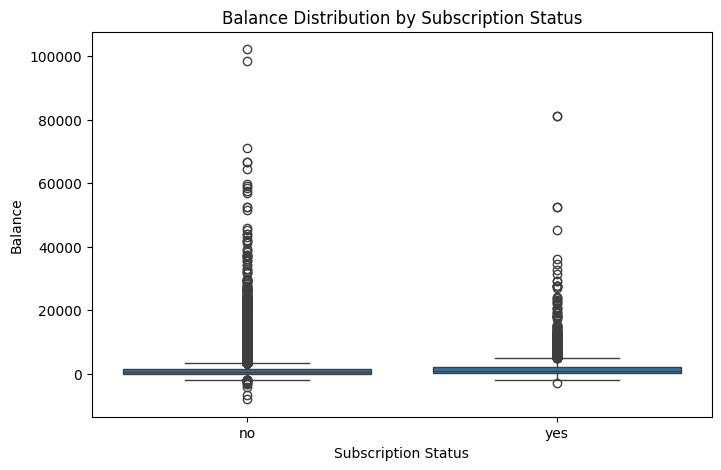

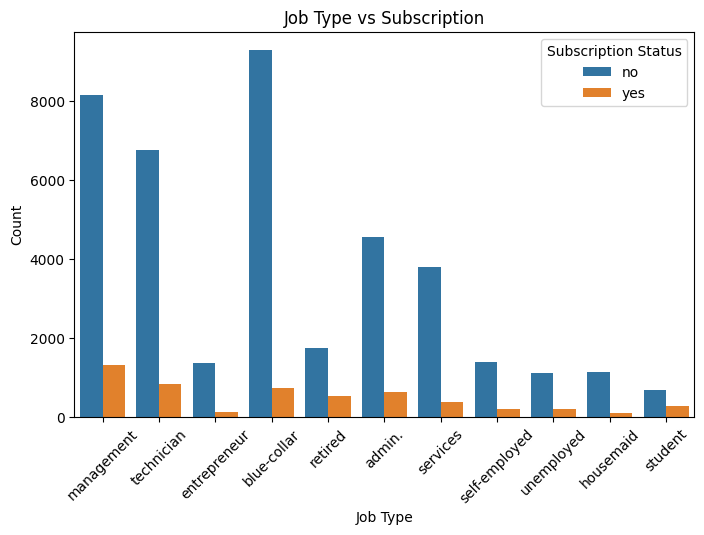

In [7]:
# Set a consistent figure size
plot_size = (8, 5)

# Boxplot for balance vs subscription status
plt.figure(figsize=plot_size)
sns.boxplot(x='y', y='balance', data=data)
plt.title('Balance Distribution by Subscription Status')
plt.xlabel('Subscription Status')
plt.ylabel('Balance')
plt.show()

# Job vs subscription
plt.figure(figsize=plot_size)
sns.countplot(x='job', hue='y', data=data)
plt.title('Job Type vs Subscription')
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Subscription Status', loc='upper right')
plt.show()

## Step 4. Correlation Analysis

Objective: Explore relationships between numerical features.

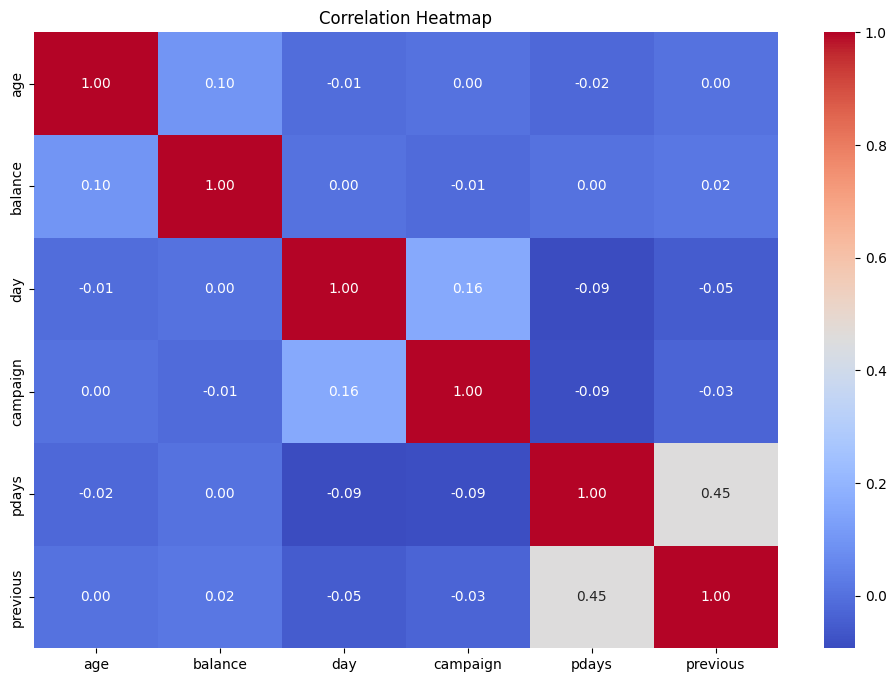

In [8]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate and visualize the correlation matrix
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap reveals that most numerical features have weak or negligible correlations, indicating low multicollinearity and diverse contributions to prediction. A notable moderate correlation (0.45) exists between pdays and previous, suggesting some redundancy, but other features like age, balance, and campaign show minimal linear relationships. This suggests that the numerical features are largely independent and suitable for modeling without significant concerns about collinearity.

## Step 5. Analysis

In [9]:
#quick recap of the dataset
print("Dataset Shape:", data.shape)
print("Columns:", data.columns.tolist())
print("Sample Data:\n", data.head())

#check for missing values
print("Missing Values:\n", data.isnull().sum())

Dataset Shape: (45211, 15)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'y']
Sample Data:
    age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married  secondary      no     1506     yes   no   
4   33   blue-collar   single  secondary      no        1      no   no   

           contact  day month  campaign  pdays  previous   y  
0  Unknown Contact    5   may         1     -1         0  no  
1  Unknown Contact    5   may         1     -1         0  no  
2  Unknown Contact    5   may         1     -1         0  no  
3  Unknown Contact    5   may         1     -1         0  no  
4  Unknown Contact    5   may         1     -

In [10]:
#convert y into binary values (yes->1, no->0)
data['y'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)
print("Target Variable Distribution:\n", data['y'].value_counts(normalize=True))
print("Numerical Features Summary:\n", data.describe())

Target Variable Distribution:
 y
0    0.883015
1    0.116985
Name: proportion, dtype: float64
Numerical Features Summary:
                 age        balance           day      campaign         pdays  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419      2.763841     40.197828   
std       10.618762    3044.765829      8.322476      3.098021    100.128746   
min       18.000000   -8019.000000      1.000000      1.000000     -1.000000   
25%       33.000000      72.000000      8.000000      1.000000     -1.000000   
50%       39.000000     448.000000     16.000000      2.000000     -1.000000   
75%       48.000000    1428.000000     21.000000      3.000000     -1.000000   
max       95.000000  102127.000000     31.000000     63.000000    871.000000   

           previous             y  
count  45211.000000  45211.000000  
mean       0.580323      0.116985  
std        2.303441      0.321406  
min        0

In [11]:
from sklearn.model_selection import train_test_split
#convert binary columns to binary numeric
binary_columns = ['default', 'housing', 'loan']
for col in binary_columns:
    data[col] = data[col].apply(lambda x: 1 if x == 'yes' else 0)

#OHE 
categorical_columns = ['job', 'marital', 'education', 'contact', 'month']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

#separate x and y
X = data_encoded.drop(columns=['y']) 
y = data_encoded['y']  

#split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)

Training Features Shape: (31647, 36)
Testing Features Shape: (13564, 36)
Training Target Shape: (31647,)
Testing Target Shape: (13564,)


In [12]:
#Save split data to processed folder
X_train.to_csv("../data/processed/X_train.csv")
X_test.to_csv("../data/processed/X_test.csv")
y_train.to_csv("../data/processed/y_train.csv")
y_test.to_csv("../data/processed/y_test.csv")

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
#using standardscalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train Logistic Regression model
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)

#Predict on the test set
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

#Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.71      0.81     11966
           1       0.23      0.66      0.34      1598

    accuracy                           0.70     13564
   macro avg       0.59      0.68      0.57     13564
weighted avg       0.86      0.70      0.75     13564

AUC Score: 0.7493101020266641


In [14]:
#Save scaled scaled files to preprocessed folder
pd.DataFrame(X_train_scaled).to_csv("../data/processed/X_train_scaled.csv")
pd.DataFrame(X_test_scaled).to_csv("../data/processed/X_test_scaled.csv")

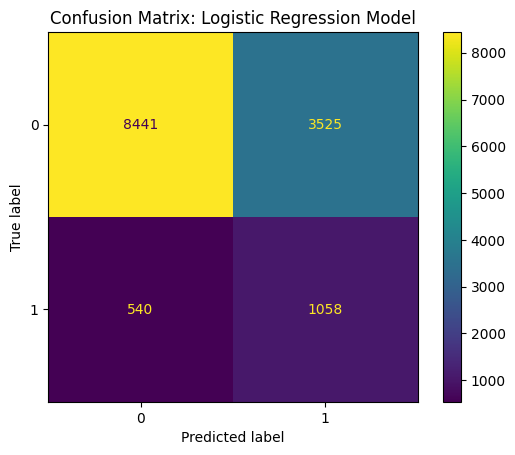

In [15]:
#Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay 

cm = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test_scaled,
    y_test,
    values_format="d",  # Show the full number 59,700 instead of 6e+04,
    # normalize='all'  # Show the proportion in each square instead of the count
)
plt.title("Confusion Matrix: Logistic Regression Model")
plt.show()

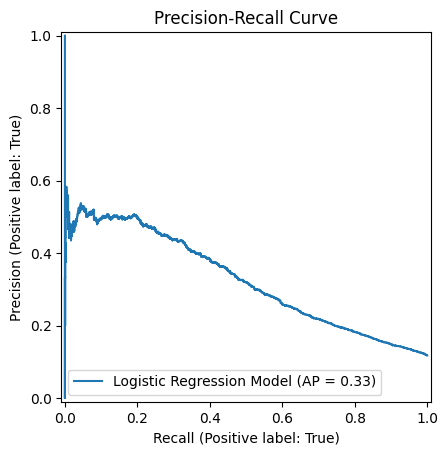

In [16]:
#Precision-Recall
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(
    model,
    X_test_scaled,
    y_test,
    pos_label=True,
    name='Logistic Regression Model'
)
plt.title("Precision-Recall Curve")
plt.show()

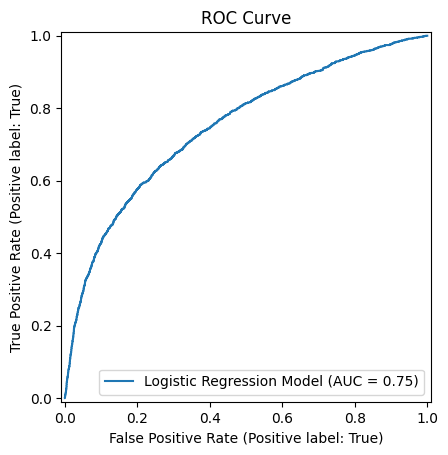

In [17]:
# 1D. ROC
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
    model,
    X_test_scaled,
    y_test,
    pos_label=True,
    name='Logistic Regression Model'
)
plt.title("ROC Curve")
plt.show()

## Discussion

The analysis of the dataset reveals several key findings about customer behavior and the performance of the logistic regression model. The dataset comprises 45,211 records, each describing a bank customer’s characteristics and whether they subscribed to a term deposit. Notably, the target variable is highly imbalanced, with only 11.7% of customers subscribing. This imbalance significantly impacts the evaluation of predictive models, making metrics like precision, recall, and the AUC score crucial for assessing model performance.

The logistic regression model achieved a macro-average recall of 0.68 and an AUC score of 0.75, indicating moderate predictive power. While the model performs well at identifying non-subscribers, it struggles with precision (0.23) for subscribers. This result aligns with expectations given the imbalanced nature of the dataset, as the model tends to predict the majority class more accurately. The class balancing approach partially mitigated this issue by improving recall for the minority class (term deposit subscribers), but precision remains a challenge.

These findings have practical implications for the bank’s marketing strategy. By leveraging the model's predictions, the bank can focus its campaigns on customers more likely to subscribe, optimizing resource allocation. However, the low precision suggests that many non-subscribers may still be targeted, potentially increasing costs and reducing campaign efficiency. Therefore, improving precision should be a focus for future modeling efforts.

This analysis raises several questions for future research:
1. Can advanced machine learning models, such as random forests or gradient boosting machines, improve predictive accuracy and precision for the minority class?
2. What role do additional features, such as transaction history or customer engagement metrics, play in predicting term deposit subscriptions?
3. How does the economic context (e.g., interest rates, market conditions) influence customer subscription behavior, and can external factors be integrated into the model?


In [18]:
#data validation
schema = pa.DataFrameSchema(
    {
        # Check column names and data types
        "age": pa.Column(int, pa.Check.between(18, 95), nullable=False),  # Age should be between 18 and 95
        "balance": pa.Column(float, pa.Check.greater_than_or_equal_to(0), nullable=False),  # Non-negative balance
        "day": pa.Column(int, pa.Check.between(1, 31), nullable=False),  # Day of the month
        "campaign": pa.Column(int, pa.Check.greater_than_or_equal_to(1), nullable=False),  # At least one campaign
        "pdays": pa.Column(int, nullable=True),  # Can include -1 (no contact)
        "previous": pa.Column(int, pa.Check.greater_than_or_equal_to(0), nullable=False),  # Non-negative previous contacts
        "job_admin.": pa.Column(int, pa.Check.isin([0, 1]), nullable=False),  # OHE job column
        "marital_married": pa.Column(int, pa.Check.isin([0, 1]), nullable=False),  # OHE marital column
        "education_primary": pa.Column(int, pa.Check.isin([0, 1]), nullable=False),  # OHE education column
        "housing": pa.Column(int, pa.Check.isin([0, 1]), nullable=False),  # Housing loan column
        "loan": pa.Column(int, pa.Check.isin([0, 1]), nullable=False),  # Personal loan column
        "contact_unknown": pa.Column(int, pa.Check.isin([0, 1]), nullable=False),  # OHE contact column
        "month_may": pa.Column(int, pa.Check.isin([0, 1]), nullable=False),  # OHE month column
        "y": pa.Column(int, pa.Check.isin([0, 1]), nullable=False)  # Target column: binary classification (0 or 1)
    },
    # Table-wide checks
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),  # No duplicate rows
        pa.Check(lambda df: ~(df.isnull().all(axis=1)).any(), error="Empty rows found.")  # No fully empty rows
    ]
)

## References

Carvalho, A., & Oliveira, J. (2014). DSS v3: A Decision Support System for data mining and machine learning (PDF). University of Minho. https://repositorium.sdum.uminho.pt/bitstream/1822/30994/1/dss-v3.pdf

Freschia Gonzales. (May 16, 2024). “More than half of Canadians don’t invest annually, CIBC poll finds.” Wealth Professional. https://www.wealthprofessional.ca/investments/wealth-technology/more-than-half-of-canadians-dont-invest-annually-cibc-poll-finds/385897

IslandSavings. (n.d.). “A Complete Guide to Term Deposits.” IslandSavings. https://www.islandsavings.ca/simple-advice/wealth/term-deposits-guide#p1 

Moro, S., Rita, P., and Cortez, P. (2014). Bank Marketing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306. 

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … & Duchesnay, É. (2024). scikit-learn: Machine learning in Python (Version 1.5). https://scikit-learn.org/1.5/index.html